In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque, defaultdict
import os
import re
import time
import sys
import matplotlib.pyplot as plt
print(f"TensorFlow Version: {tf.__version__}")
print("All libraries imported.")

2025-11-03 10:54:23.126285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762167263.305796      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762167263.362636      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
All libraries imported.


In [2]:

# --- CONFIG ---
#BASE_PATH = '/kaggle/input/hackman'/kaggle/input/hackman'
CORPUS_FILE = "/kaggle/input/hackman/corpus.txt"
TEST_FILE = "/kaggle/input/hackman/test.txt"

ACTION_SIZE = 26
REPLAY_BUFFER_SIZE = 50000
BATCH_SIZE = 64
GAMMA = 0.99
LEARNING_RATE = 1e-4

EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY_STEPS = 80000

TARGET_UPDATE_FREQ = 1000
NUM_EPISODES_TRAIN = 25000
NUM_EPISODES_EVAL = 2000
MAX_LIVES = 6

# --- LOAD WORDS ---
def load_words(filepath):
    with open(filepath, 'r') as f:
        words = f.read().splitlines()
    cleaned = [w.lower().strip() for w in words if re.fullmatch(r'[a-z]+', w)]
    print(f"Loaded {len(cleaned)} words from {filepath}")
    return cleaned

corpus_words = load_words(CORPUS_FILE)
eval_words = load_words(TEST_FILE)

corpus_by_length = defaultdict(list)
for w in corpus_words:
    corpus_by_length[len(w)].append(w)

MAX_WORD_LEN = max(max(len(w) for w in corpus_words), max(len(w) for w in eval_words))
STATE_VECTOR_SIZE = MAX_WORD_LEN + 26 + 26 + 1
print(f"Max word length: {MAX_WORD_LEN}, State vector size: {STATE_VECTOR_SIZE}")


Loaded 49979 words from /kaggle/input/hackman/corpus.txt
Loaded 2000 words from /kaggle/input/hackman/test.txt
Max word length: 24, State vector size: 77


In [3]:
# ==========================================
# PHASE 2: Probabilistic Oracle (HMM)
# ==========================================
class ProbabilisticOracle:
    def __init__(self, corpus_words):
        self.words_by_length = defaultdict(list)
        for w in corpus_words:
            self.words_by_length[len(w)].append(w)

        self.general_freqs = defaultdict(int)
        total = 0
        for w in corpus_words:
            for c in w:
                self.general_freqs[c] += 1
                total += 1
        for c in self.general_freqs:
            self.general_freqs[c] /= total
        self.regex_cache = {}

    def get_candidate_words(self, masked_word_list, guessed_letters):
        L = len(masked_word_list)
        if L not in self.words_by_length:
            return []
        masked_tuple = tuple(masked_word_list)
        guessed_tuple = tuple(sorted(list(guessed_letters)))
        cache_key = (masked_tuple, guessed_tuple)
        if cache_key in self.regex_cache:
            return self.regex_cache[cache_key]

        wrong_guesses = guessed_letters.difference(set(masked_word_list))
        neg_set = "".join(sorted(list(wrong_guesses)))
        pattern = ""
        for ch in masked_word_list:
            if ch == '_':
                pattern += f"[^{neg_set}]" if neg_set else "."
            else:
                pattern += re.escape(ch)
        regex = re.compile(f"^{pattern}$")
        candidates = [w for w in self.words_by_length[L] if regex.match(w)]
        self.regex_cache[cache_key] = candidates
        return candidates

    def get_probabilities(self, masked_word_list, guessed_letters):
        candidates = self.get_candidate_words(masked_word_list, guessed_letters)
        freq_map = defaultdict(int)
        total_valid = 0
        if candidates:
            for w in candidates:
                for i, c in enumerate(w):
                    if masked_word_list[i] == '_' and c not in guessed_letters:
                        freq_map[c] += 1
                        total_valid += 1
        probs = np.zeros(ACTION_SIZE)
        if total_valid > 0:
            for c, count in freq_map.items():
                probs[ord(c) - 97] = count / total_valid
        else:
            for i in range(ACTION_SIZE):
                c = chr(97 + i)
                if c not in guessed_letters:
                    probs[i] = self.general_freqs.get(c, 0.001)
        probs /= np.sum(probs) if np.sum(probs) > 0 else 1
        return probs

print("Probabilistic Oracle defined.")



Probabilistic Oracle defined.


In [4]:
# ==========================================
# PHASE 3: Hangman Environment
# ==========================================
REWARD_WIN = 100
REWARD_LOSS = -100
REWARD_CORRECT_GUESS = 5
REWARD_WRONG_GUESS = -5
REWARD_REPEATED_GUESS = -2

class HangmanEnv:
    def __init__(self, word_list, oracle, max_lives=6):
        self.words = word_list
        self.oracle = oracle
        self.max_lives = max_lives
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        print("HangmanEnv initialized.")

    def _get_state(self):
        word_vec = np.zeros(MAX_WORD_LEN)
        for i, ch in enumerate(self.masked_word):
            word_vec[i] = (ord(ch) - 96)/26 if ch != '_' else 0
        guessed_vec = np.zeros(ACTION_SIZE)
        for g in self.guessed:
            guessed_vec[ord(g) - 97] = 1
        hmm_probs = self.oracle.get_probabilities(self.masked_word, self.guessed)
        lives_vec = np.array([self.lives / self.max_lives])
        return np.concatenate((word_vec, guessed_vec, hmm_probs, lives_vec))

    def reset(self, word=None):
        self.word = word or random.choice(self.words)
        self.masked_word = ['_'] * len(self.word)
        self.guessed = set()
        self.lives = self.max_lives
        self.oracle.regex_cache = {}
        return self._get_state()

    def step(self, action):
        letter = self.alphabet[action]
        if letter in self.guessed:
            return self._get_state(), REWARD_REPEATED_GUESS, False, {'repeat': True}
        self.guessed.add(letter)
        if letter in self.word:
            for i, c in enumerate(self.word):
                if c == letter:
                    self.masked_word[i] = letter
            reward = REWARD_CORRECT_GUESS
        else:
            self.lives -= 1
            reward = REWARD_WRONG_GUESS
        done = '_' not in self.masked_word or self.lives <= 0
        if done:
            reward += REWARD_WIN if '_' not in self.masked_word else REWARD_LOSS
        return self._get_state(), reward, done, {}

print("HangmanEnv defined.")

HangmanEnv defined.


In [5]:
# ==========================================
# PHASE 4: DQN Agent
# ==========================================
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=REPLAY_BUFFER_SIZE)
        self.epsilon = EPSILON_START
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        self.loss_fn = tf.keras.losses.Huber()

    def _build_model(self):
        return models.Sequential([
            layers.Input(shape=(self.state_size,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state, guessed):
        if np.random.rand() < self.epsilon:
            avail = [i for i in range(self.action_size) if chr(97 + i) not in guessed]
            return random.choice(avail)
        q = self.model(np.expand_dims(state, axis=0))[0].numpy()
        q[[ord(g)-97 for g in guessed]] = -np.inf
        return int(np.argmax(q))

    def store(self, s, a, r, ns, d):
        self.memory.append((s, a, r, ns, d))

    @tf.function
    def train_step(self, s, a, r, ns, d):
        # Convert to float for calculation
        d = tf.cast(d, tf.float32)
        r = tf.cast(r, tf.float32) # Cast reward to float32

        # Compute target Q-values
        next_q = self.target_model(ns, training=False)
        max_next = tf.reduce_max(next_q, axis=1)
        target = r + (1.0 - d) * GAMMA * max_next

        with tf.GradientTape() as tape:
            q_vals = self.model(s, training=True)
            mask = tf.one_hot(a, self.action_size)
            q_action = tf.reduce_sum(q_vals * mask, axis=1)
            loss = self.loss_fn(target, q_action)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        s, a, r, ns, d = map(np.array, zip(*batch))
        self.train_step(s, a, r, ns, d)
        if self.epsilon > EPSILON_END:
            self.epsilon -= (EPSILON_START - EPSILON_END) / EPSILON_DECAY_STEPS

print("DQN Agent ready.")

DQN Agent ready.


HangmanEnv initialized.


I0000 00:00:1762167275.788046      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762167275.788766      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Episode 200 | Avg Reward: -118.08 | ε=0.981
Episode 400 | Avg Reward: -117.17 | ε=0.960
Episode 600 | Avg Reward: -116.58 | ε=0.940
Episode 800 | Avg Reward: -118.05 | ε=0.920
Episode 1000 | Avg Reward: -113.38 | ε=0.899
Episode 1200 | Avg Reward: -115.53 | ε=0.878
Episode 1400 | Avg Reward: -113.75 | ε=0.857
Episode 1600 | Avg Reward: -110.90 | ε=0.836
Episode 1800 | Avg Reward: -115.28 | ε=0.814
Episode 2000 | Avg Reward: -113.20 | ε=0.793
Episode 2200 | Avg Reward: -106.35 | ε=0.770
Episode 2400 | Avg Reward: -108.08 | ε=0.748
Episode 2600 | Avg Reward: -107.72 | ε=0.726
Episode 2800 | Avg Reward: -95.15 | ε=0.703
Episode 3000 | Avg Reward: -95.65 | ε=0.680
Episode 3200 | Avg Reward: -93.80 | ε=0.657
Episode 3400 | Avg Reward: -95.62 | ε=0.634
Episode 3600 | Avg Reward: -91.75 | ε=0.611
Episode 3800 | Avg Reward: -80.53 | ε=0.587
Episode 4000 | Avg Reward: -71.90 | ε=0.563
Episode 4200 | Avg Reward: -67.05 | ε=0.539
Episode 4400 | Avg Reward: -48.17 | ε=0.514
Episode 4600 | Avg Rewa

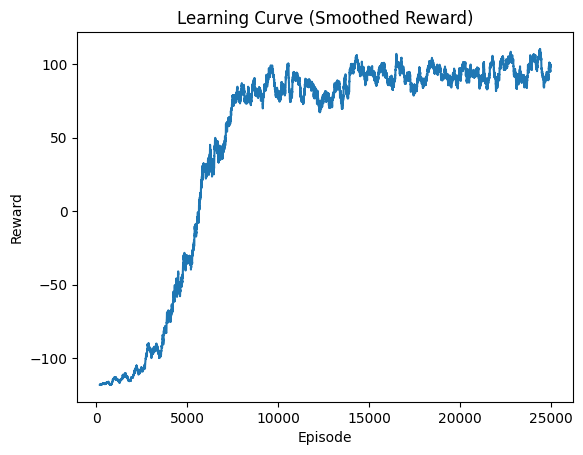

In [6]:
# ==========================================
# PHASE 5: Training
# ==========================================
oracle = ProbabilisticOracle(corpus_words)
env = HangmanEnv(corpus_words, oracle)
agent = DQNAgent(STATE_VECTOR_SIZE, ACTION_SIZE)

rewards = []
for ep in range(NUM_EPISODES_TRAIN):
    s = env.reset()
    done = False
    total = 0
    while not done:
        a = agent.act(s, env.guessed)
        ns, r, done, _ = env.step(a)
        agent.store(s, a, r, ns, done)
        agent.replay()
        s = ns
        total += r
    if ep % TARGET_UPDATE_FREQ == 0:
        agent.update_target()
    rewards.append(total)
    if (ep+1) % 200 == 0:
        print(f"Episode {ep+1} | Avg Reward: {np.mean(rewards[-200:]):.2f} | ε={agent.epsilon:.3f}")


# ==========================================
# PHASE 6: Evaluation
# ==========================================
agent.epsilon = 0
eval_oracle = ProbabilisticOracle(corpus_words)
eval_env = HangmanEnv(eval_words, eval_oracle)

total_games = NUM_EPISODES_EVAL
total_wins = 0
total_wrong_guesses = 0
total_repeated_guesses = 0

for w in eval_words[:NUM_EPISODES_EVAL]:
    s = eval_env.reset(word=w)
    done = False
    wrong_guesses = 0
    repeated_guesses = 0
    while not done:
        a = agent.act(s, eval_env.guessed)
        s, r, done, info = eval_env.step(a)
        if r == REWARD_WRONG_GUESS:
            wrong_guesses += 1
        elif 'repeat' in info:
            repeated_guesses += 1

    if '_' not in eval_env.masked_word:
        total_wins += 1
    total_wrong_guesses += wrong_guesses
    total_repeated_guesses += repeated_guesses


print(f"✅ Final Success Rate: {(total_wins/total_games)*100:.2f}%")

plt.plot(pd.Series(rewards).rolling(200).mean())
plt.title("Learning Curve (Smoothed Reward)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [7]:
# --- Final Evaluation and Scoring ---

losses = total_games - total_wins

success_rate = (total_wins / total_games) * 100
avg_wrong = total_wrong_guesses / total_games
avg_repeat = total_repeated_guesses / total_games

# scoring
win_component = (success_rate/100) * total_games
wrong_penalty = total_wrong_guesses * 5
repeat_penalty = total_repeated_guesses * 2

final_score = win_component - wrong_penalty - repeat_penalty

# --- Final Output ---

print("\n--- Final Results ---")
print(f"Total Games Played: {total_games}")
print(f"Success Rate: {success_rate:.2f}% ({total_wins} wins)")
print(f"Total Wrong Guesses: {total_wrong_guesses}")
print(f"Total Repeated Guesses: {total_repeated_guesses}")
print(f"Avg. Wrong Guesses: {avg_wrong:.2f}")
print(f"Avg. Repeated Guesses: {avg_repeat:.2f}")

print("\n--- Scoring Breakdown  ---")
print(f"Win Component (Success Rate * {total_games}): {win_component:.2f}")
print(f"Wrong Guess Penalty (Total * 5): -{wrong_penalty}")
print(f"Repeated Guess Penalty (Total * 2): -{repeat_penalty}")

print(f"\nFinal Score: {final_score:.2f}")


--- Final Results ---
Total Games Played: 2000
Success Rate: 13.20% (264 wins)
Total Wrong Guesses: 9733
Total Repeated Guesses: 0
Avg. Wrong Guesses: 4.87
Avg. Repeated Guesses: 0.00

--- Scoring Breakdown  ---
Win Component (Success Rate * 2000): 264.00
Wrong Guess Penalty (Total * 5): -48665
Repeated Guess Penalty (Total * 2): -0

Final Score: -48401.00
